# pymoo

[pymoo](https://pymoo.org/) is a pure-python package for (constrained) single- and multi-objective optimization.  
The following notebook is loosely based on the [getting-started guide](https://pymoo.org/getting_started.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymoo
pymoo.__version__

'0.3.2'

### Multi-Objective Optimization

In general, multi-objective optimization has several objective functions with subject to inequality and equality constraints to optimize <cite data-cite="multi_objective_book"></cite>. The goal is to find a set of solutions that do not have any constraint violation and are as good as possible regarding all its objectives values. The problem definition in its general form is given by:

\begin{align}
\begin{split}
\min \quad& f_{m}(x) \quad \quad \quad \quad m = 1,..,M  \\[4pt]
\text{s.t.}   \quad& g_{j}(x) \leq 0  \quad \; \; \,  \quad j = 1,..,J \\[2pt]
\quad& h_{k}(x) = 0        \quad  \; \; \quad k = 1,..,K \\[4pt]
\quad& x_{i}^{L} \leq x_{i} \leq x_{i}^{U}  \quad i = 1,..,N \\[2pt]
\end{split}
\end{align}

The formulation above defines a multi-objective optimization problem with $N$ variables, $M$ objectives, $J$ inequality and $K$ equality constraints. Moreover, for each variable $x_i$ lower and upper variable boundaries ($x_i^L$ and $x_i^U$) are defined.

Note that equality constraints are not directly supported in pymoo and have to be constructed from two inequality constraints with a finite allowed range, see https://github.com/msu-coinlab/pymoo/issues/19 and https://github.com/msu-coinlab/pymoo/blob/master/doc/source/misc/constraint_handling.ipynb

### Example Optimization Problem

pymoo has various single- and many-objective optimization test problems already [implemented](https://pymoo.org/problems/index.html#Test-Problems).

In the following, we investigate the following custom toy problem with two variables, two objectives and two constraints:

\begin{align}
\min \;\; & f_1(x) = (x_1^2 + x_2^2) \\
\min \;\; & f_2(x) = (x_1-1)^2 + x_2^2 \\
\text{s.t.} \;\; & g_1(x) = (x_1 - 0.1) \, (x_1 - 0.9) \leq 0\\
& g_2(x) = - (x_1 - 0.4) \, (x_1 - 0.6) \leq 0\\
& -2 \leq x_1 \leq 2 \\
& -2 \leq x_2 \leq 2
\end{align}

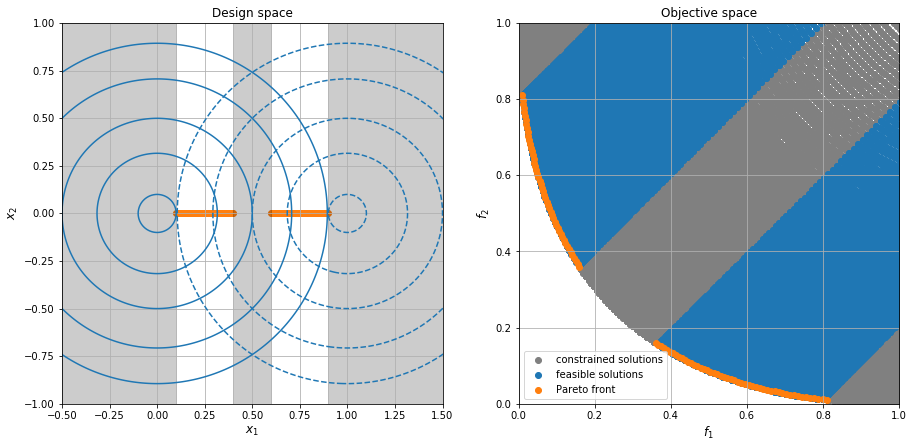

In [2]:
X1, X2 = np.meshgrid(np.linspace(-2, 2, 500), np.linspace(-2, 2, 500))
F1 = X1**2 + X2**2
F2 = (X1-1)**2 + X2**2
G1 = (X1 - 0.1) * (X1 - 0.9) <= 0
G2 = (X1 - 0.4) * (X1 - 0.6) >= 0
G = G1 * G2

x1 = np.r_[np.linspace(0.1, 0.4, 50), np.linspace(0.6, 0.9, 50)]
F_pareto = np.column_stack([x1**2, (x1 - 1)**2]) 
X_pareto = np.column_stack([x1, np.zeros_like(x1)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.contour(X1, X2, F1, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0")
ax1.contour(X1, X2, F2, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0", linestyles="dashed")
ax1.scatter(*X_pareto.T, color="C1")
ax1.axvspan(-0.5, 0.1, color="black", alpha=0.2)
ax1.axvspan(0.4, 0.6, color="black", alpha=0.2)
ax1.axvspan(0.9, 1.5, color="black", alpha=0.2)
ax1.set(xlim=(-0.5, 1.5), ylim=(-1, 1), xlabel="$x_1$", ylabel="$x_2$", title="Design space")
ax1.grid();

ax2.scatter(F1[~G].flat, F2[~G].flat, color="gray", label="constrained solutions")
ax2.scatter(F1[G].flat, F2[G].flat, label="feasible solutions")
ax2.scatter(*F_pareto.T, color="C1", label="Pareto front")
ax2.set(xlim=(0, 1), ylim=(0, 1), xlabel="$f_1$", ylabel="$f_2$", title="Objective space")
ax2.legend()
ax2.grid();

In the design space on the left the circular contours show the two objectives, which are minimal at the design points (0, 0) and (1, 0). 
The inequality constraints are independent of $x_2$ and constrain the design space to two disjoint regions $x_1 \in [0.1, 0.4] \cup [0.6, 0.9]$, thus excluding the minima of the individual objectives. The Pareto front (orange) is composed of the feasible points along $x_2 = 0$.  

### Problem Definition

Each optimization problem in pymoo has to inherit from the Problem class and initialize the number of variables `n_var`, objectives `n_obj` and constraints `n_constr` as well as the lower and upper variable bounds. Additionally, the `_evaluate` method needs to be implemented, returning the objective values and constraints for a given 2D input array, where each row represents an individual and each column an optimization variable. Note that we're using `autograd.numpy` here so that the returned arrays can be automatically differentiated if the optimization algorithm requires gradients.   
If the Pareto front is known, corresponding methods for returning a representative set of Pareto-efficient objectives and their design variables can be implemented. This can be used for the built-in plotting functions and for calculating performance metrics such as the GD and IGD.

In [3]:
import autograd.numpy as anp
from pymoo.util.misc import stack
from pymoo.model.problem import Problem

class MyProblem(Problem):

    def __init__(self):
        super().__init__(
            n_var=2, 
            n_obj=2, 
            n_constr=2, 
            xl=anp.array([-2, -2]), 
            xu=anp.array([2, 2])
        )

    def _evaluate(self, x, out, *args, **kwargs):
        x1, x2 = x.T
        f1 = x1 ** 2 + x2 ** 2
        f2 = (x1 - 1) ** 2 + x2 ** 2
        g1 = (x1 - 0.1) * (x1 - 0.9)
        g2 = - (x1 - 0.4) * (x1 - 0.6)
        out["F"] = anp.column_stack([f1, f2])
        out["G"] = anp.column_stack([g1, g2])

    def _calc_pareto_front(self, **kwargs):
        return F_pareto
    
    def _calc_pareto_set(self, **kwargs):
        return X_pareto
    
problem = MyProblem()

### Optimization

*pymoo* offers various [algorithms](algorithms/index.ipynb) which can be used to solve problems with different characteristics.
In general, the choice of a suitable algorithm for optimization problems is a challenge itself. Whenever problem characteristics are known beforehand, we recommended using those through customized operators.
However, in our case the optimization problem is rather simple, but the aspect of having two objectives and two constraints should be considered. For this reason, we decided to use [NSGA-II](algorithms/nsga2.ipynb) with its default configuration with minor modifications. We chose a population size of 40 (`pop_size=40`) and decided instead of generating the same number of offsprings to create only 10 (`n_offsprings=40`). This is a greedier  variant and improves the convergence of rather simple optimization problems without difficulties regarding optimization, such as the existence of local Pareto fronts.
Moreover, we enable a duplicate check (`eliminate_duplicates=True`) which makes sure that the mating produces offsprings which are different with respect to themselves and the existing population regarding their design space values.

We stop the optimization after 20 generations.

In [4]:
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation, get_termination
from pymoo.optimize import minimize

algorithm = NSGA2(
    pop_size=40,
    n_offsprings=20,
    sampling=get_sampling("real_random"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
    eliminate_duplicates=True  # enforce different x in offsprings
)

results = minimize(
    problem,
    algorithm,
    get_termination("n_gen", 20),
    seed=1,
    pf=problem.pareto_front(use_cache=False),
    save_history=True,
    verbose=True)

n_gen | n_eval  | cv (min/avg)                | igd          | gd           | hv          
1     | 40      | 0.0000000000 / 2.1275926754 | 0.3429833109 | 1.1144034634 | 0.2593402332
2     | 60      | 0.0000000000 / 0.6284760090 | 0.3105453669 | 0.8186008792 | 0.2701222978
3     | 80      | 0.0000000000 / 0.1841527592 | 0.3096421172 | 0.8733471256 | 0.2701222978
4     | 100     | 0.0000000000 / 0.0283912199 | 0.2944655150 | 0.9663206760 | 0.2865135253
5     | 120     | 0.0000000000 / 0.0000703975 | 0.1257239956 | 0.8718059133 | 0.3943012349
6     | 140     | 0.0000000000 / 0.0000000000 | 0.0787948824 | 0.2185996847 | 0.4231124422
7     | 160     | 0.0000000000 / 0.0000000000 | 0.0399193360 | 0.0787794275 | 0.4384104057
8     | 180     | 0.0000000000 / 0.0000000000 | 0.0358633864 | 0.0245031879 | 0.4407945589
9     | 200     | 0.0000000000 / 0.0000000000 | 0.0266029119 | 0.0184686082 | 0.4452906571
10    | 220     | 0.0000000000 / 0.0000000000 | 0.0274728472 | 0.0156830859 | 0.4467153400

With `verbose=True` the progress in terms of hypervolume (using the observed nadir as reference point I assume), and the (inverted) generational distance are listed, if the pareto front was provided as part of the problem definition. However, the metrics are not saved in the results object, so we have to recompute them below.

### Results

The results object contains
* `results.X` design space values are
* `results.F` objective spaces values
* `results.G` constraint values
* `results.CV` aggregated constraint violation
* `results.algorithm` algorithm object
* `results.pop` final population object
* `results.history` history of algorithm object. (only if save_history has been enabled during the algorithm initialization)

Looking at the last generation we can that the algorithm was able to converge, and a set of nearly-optimal solutions was obtained (black crosses). 

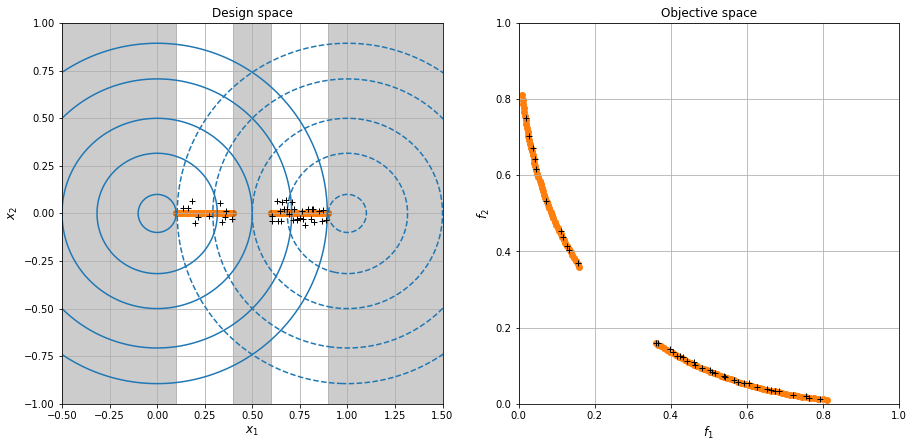

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.contour(X1, X2, F1, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0")
ax1.contour(X1, X2, F2, levels=[0.01, 0.1, 0.25, 0.5, 0.8], colors="C0", linestyles="dashed")
ax1.scatter(*X_pareto.T, color="C1")
ax1.axvspan(-0.5, 0.1, color="black", alpha=0.2)
ax1.axvspan(0.4, 0.6, color="black", alpha=0.2)
ax1.axvspan(0.9, 1.5, color="black", alpha=0.2)
ax1.set(xlim=(-0.5, 1.5), ylim=(-1, 1), xlabel="$x_1$", ylabel="$x_2$", title="Design space")
ax1.grid()

ax2.scatter(*F_pareto.T, color="C1")
ax2.set(xlim=(0, 1), ylim=(0, 1), xlabel="$f_1$", ylabel="$f_2$", title='Objective space')
ax2.grid()

ax1.plot(*results.X.T, 'k+')
ax2.plot(*results.F.T, 'k+');

If the optimization scenario is repetitive it makes sense to track the performance of the algorithm. Because we have stored the history of the optimization run, we can now analyze the convergence over time. To measure the performance, we need to decide what metric to be used.

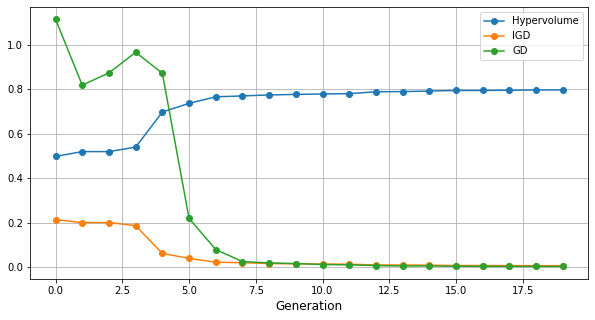

In [6]:
from pymoo.performance_indicator.hv import Hypervolume
from pymoo.factory import get_performance_indicator

pops = [a.pop for a in results.history]  # collect the population in each generation
objs = [pop[pop.get("feasible")[:,0]].get("F") for pop in pops]  # collect the (feasible) objective values

hv = [Hypervolume(ref_point=np.array([1.0, 1.0])).calc(A) for A in objs]
igd = [get_performance_indicator("igd+", F_pareto).calc(A) for A in objs]
gd = [get_performance_indicator("gd+", F_pareto).calc(A) for A in objs]

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hv, '-o', label='Hypervolume')
ax.plot(igd, '-o', label='IGD')
ax.plot(gd, '-o', label='GD')
ax.legend();
ax.set(xlabel="Generation")
ax.grid();